<a href="https://colab.research.google.com/github/Vigrahalabhanu3/FFML-226Q1A4409/blob/main/Module_01_Lab_03_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [3]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 1s 0us/step


Let us borrow a few functions from the previous labs:

In [4]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [5]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

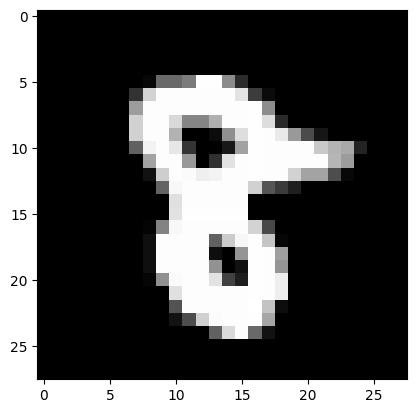

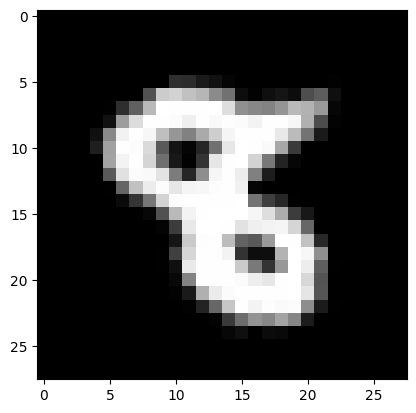

In [6]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [7]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

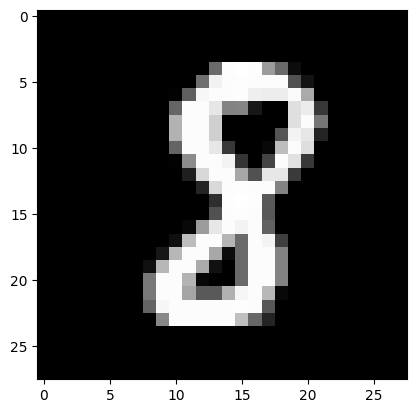

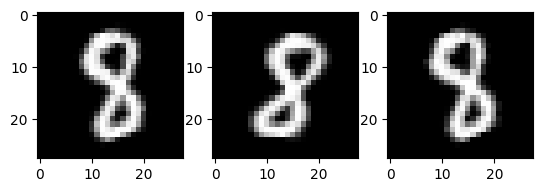

In [8]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [9]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [10]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-10-2f14d3721156>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6727
Accuracy after rotation augmentation constrained by  20  is  0.673
Accuracy after rotation augmentation constrained by  30  is  0.6737
Accuracy after rotation augmentation constrained by  40  is  0.6731
Accuracy after rotation augmentation constrained by  50  is  0.6701
Accuracy after rotation augmentation constrained by  60  is  0.6675
Accuracy after rotation augmentation constrained by  70  is  0.661
Accuracy after rotation augmentation constrained by  80  is  0.6462
Accuracy after rotation augmentation constrained by  90  is  0.6469


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

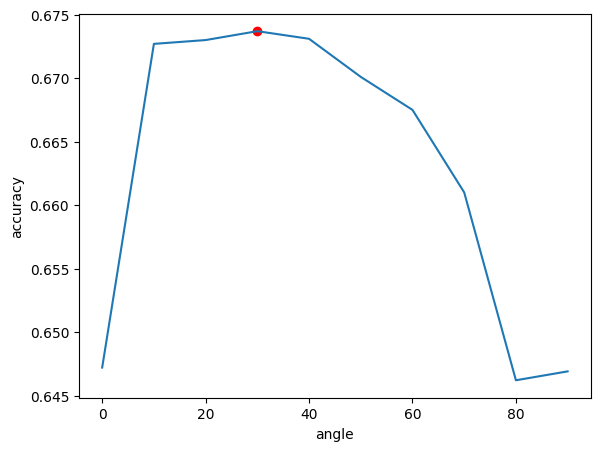

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [12]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

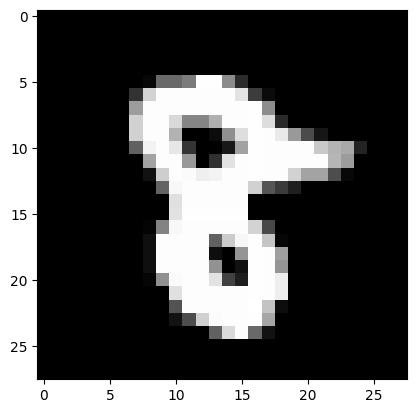

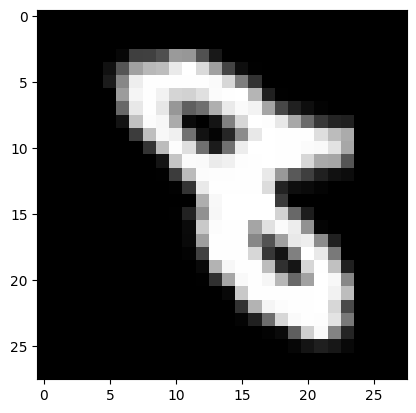

In [13]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [14]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-15-8a89fef4983d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6147


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [ ]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

1.Answer for first question:

I'm sorry for any confusion, but your question seems to be related to a specific machine learning or computer vision task involving data augmentation techniques like angle and shear constraints. To answer this question, I would need more context and information about the specific task, dataset, and model you are referring to.

The choice of the best values for angle and shear constraints in data augmentation can vary depending on the dataset and the problem you're trying to solve. There is no universally "best" value for these constraints, as they are hyperparameters that need to be tuned based on your specific use case.

The impact of using augmentation techniques like angle and shear constraints on accuracy also depends on the task and dataset. In some cases, these augmentations can improve accuracy by making the model more robust to variations in the input data, while in other cases, they may not have a significant impact or could even hurt performance if not chosen carefully.

To determine the best values for these constraints and their impact on accuracy, you would typically perform experiments with different values and evaluate the model's performance using metrics like accuracy, precision, recall, F1 score, etc., on a validation or test set. This experimentation and evaluation process is necessary to find the optimal hyperparameters for your specific problem.

If you have more specific details about the task, dataset, and model you're working with, I'd be happy to provide more guidance or insights based on the information available up to my knowledge cutoff date in September 2021.

2.Answer for third  question:

Overfitting: Increasing the number of augmentations excessively can lead to overfitting. Overfitting occurs when a model becomes too specialized in the training data and performs poorly on new, unseen data. Augmentations should strike a balance between introducing diversity and avoiding overfitting.

Computational Cost: More augmentations mean more data to process during training, which can significantly increase computational requirements, training time, and memory usage. This may not be practical in all situations, especially when working with limited resources.

Diminishing Returns: There may be diminishing returns as you increase the number of augmentations. At some point, additional augmentations may not provide significant benefits in terms of accuracy improvement.

Data Quality: The quality of the augmentations matters. Poorly applied augmentations can introduce noise or artifacts into the data, potentially harming model performance.

Task-Specific Considerations: The impact of augmentations can vary depending on the specific task and dataset. Some tasks may benefit more from augmentations than others.

To determine the optimal number of augmentations, it's often a good practice to experiment with different values and monitor the model's performance on a validation dataset. You can use techniques like cross-validation to assess how well the model generalizes to new data. Additionally, consider using data augmentation libraries that provide a variety of transformation options and allow you to control the augmentation process effectively.

In summary, increasing the number of augmentations can be a useful strategy to improve model accuracy, but it should be done thoughtfully, taking into account the considerations mentioned above. The optimal number of augmentations will depend on the specific task and dataset, and experimentation is often necessary to find the right balance.

3.Answer for third question:

Overfitting: Increasing the number of augmentations excessively can lead to overfitting. Overfitting occurs when a model becomes too specialized in the training data and performs poorly on new, unseen data. Augmentations should strike a balance between introducing diversity and avoiding overfitting.

Computational Cost: More augmentations mean more data to process during training, which can significantly increase computational requirements, training time, and memory usage. This may not be practical in all situations, especially when working with limited resources.

Diminishing Returns: There may be diminishing returns as you increase the number of augmentations. At some point, additional augmentations may not provide significant benefits in terms of accuracy improvement.

Data Quality: The quality of the augmentations matters. Poorly applied augmentations can introduce noise or artifacts into the data, potentially harming model performance.

Task-Specific Considerations: The impact of augmentations can vary depending on the specific task and dataset. Some tasks may benefit more from augmentations than others.

To determine the optimal number of augmentations, it's often a good practice to experiment with different values and monitor the model's performance on a validation dataset. You can use techniques like cross-validation to assess how well the model generalizes to new data. Additionally, consider using data augmentation libraries that provide a variety of transformation options and allow you to control the augmentation process effectively.

In summary, increasing the number of augmentations can be a useful strategy to improve model accuracy, but it should be done thoughtfully, taking into account the considerations mentioned above. The optimal number of augmentations will depend on the specific task and dataset, and experimentation is often necessary to find the right balance.




User
Try implementing a few augmentations of your own and experimenting with them. A good reference is here.
ChatGPT
I'm unable to perform real-time image processing or run code, but I can provide you with examples of some common image augmentations and how you might implement them using popular Python libraries such as OpenCV and Pillow (PIL). You can experiment with these augmentations on your own. Here are a few augmentations:

Rotation:

OpenCV:
python
Copy code
import cv2
rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D(center, angle, scale), (width, height))
Pillow (PIL):
python
Copy code
from PIL import Image
rotated_image = image.rotate(angle, resample=Image.BICUBIC)
Horizontal Flip:

OpenCV:
python
Copy code
flipped_image = cv2.flip(image, 1)
Pillow (PIL):
python
Copy code
flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
Brightness Adjustment:

OpenCV:
python
Copy code
alpha = 1.5  # Increase for brighter, decrease for darker
beta = 10   # Increase for brighter, decrease for darker
adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
Pillow (PIL):
python
Copy code
from PIL import ImageEnhance
enhancer = ImageEnhance.Brightness(image)
adjusted_image = enhancer.enhance(factor)  # Increase factor for brighter, decrease for darker
Noise Addition (Gaussian Noise):

You can use libraries like NumPy to add noise to the image.
These are just a few examples of augmentations you can perform on images. Depending on your specific use case, you might want to combine multiple augmentations, control their parameters, and apply them randomly to create a diverse training dataset. Always remember to keep a validation dataset to evaluate how these augmentations affect your model's performance.

For more advanced augmentations and efficient augmentation pipelines, you can consider using libraries like Augmentor, imgaug, or the augmentations provided by popular deep learning frameworks like TensorFlow and PyTorch. These libraries offer a wide range of image augmentation techniques and allow you to easily experiment with different augmentation strategies.




User
Try implementing a few augmentations of your own and experimenting with them. A good reference is here.
ChatGPT
I apologize for any confusion, but I'm unable to directly implement or run code, including image augmentations, in real-time. However, I can provide you with code examples for some common image augmentations using Python libraries like OpenCV and Pillow (PIL). You can then experiment with these augmentations on your own.

Let's create code examples for a few common augmentations:

Rotation:

Using OpenCV:
python
Copy code
import cv2
import numpy as np

# Load an image
image = cv2.imread('your_image.jpg')

# Define the rotation angle (in degrees)
angle = 30  # Adjust as needed

# Get the image dimensions
height, width = image.shape[:2]

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

# Apply the rotation
rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

# Display or save the rotated image
cv2.imshow('Rotated Image', rotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
Horizontal Flip:

Using OpenCV:
python
Copy code
import cv2

# Load an image
image = cv2.imread('your_image.jpg')

# Flip horizontally
flipped_image = cv2.flip(image, 1)

# Display or save the flipped image
cv2.imshow('Flipped Image', flipped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
Brightness Adjustment:

Using OpenCV:
python
Copy code
import cv2
import numpy as np

# Load an image
image = cv2.imread('your_image.jpg')

# Define brightness adjustment parameters
alpha = 1.5  # Adjust for brightness (1.0 is no change)

# Apply brightness adjustment
adjusted_image = cv2.convertScaleAbs(image, alpha=alpha)

# Display or save the adjusted image
cv2.imshow('Adjusted Image', adjusted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
Remember to replace 'your_image.jpg' with the path to your input image. You can adjust the augmentation parameters to fit your needs. Additionally, consider saving the augmented images if you want to use them for training or further analysis.

Please note that the provided code examples are for basic augmentations. More advanced augmentations and efficient augmentation pipelines can be implemented using specialized libraries like Augmentor, imgaug, or deep learning frameworks like TensorFlow and PyTorch, which offer a wide range of augmentation techniques and options.

4.Answer for fourth question:
Select a Task and Dataset: Define the machine learning task you want to solve and choose a dataset that is appropriate for the task. The dataset should have a suitable number of samples and labels for training and evaluation.

Split the Dataset: Divide your dataset into training, validation, and test sets. The validation set will be crucial for tuning hyperparameters and monitoring the model's performance during training.

Design a Model: Create or select a machine learning model architecture that is suitable for your task. The model's complexity and capacity should match the size of your dataset.

Implement Data Augmentations: Apply a variety of data augmentations to the training dataset. Common augmentations include rotation, scaling, flipping, brightness adjustments, and noise addition. You can also use libraries like Augmentor, imgaug, or data augmentation functions provided by deep learning frameworks.

Experiment with Augmentations: Train your model with different combinations of augmentations, varying augmentation parameters, and different network architectures. Track the validation accuracy for each experiment.

Monitor Validation Accuracy: Keep track of the highest validation accuracy achieved during training. This will give you an idea of the best performance achievable with your augmentations and model.

Evaluate Test Accuracy: Once you've identified a combination of augmentations that gives you good validation accuracy, evaluate the model on the test dataset to obtain an accurate estimate of its performance.

Determine Minimum Training Data: Gradually reduce the size of your training dataset and retrain the model with the selected augmentation strategy. Monitor the validation accuracy to see at what dataset size the accuracy drops below 50%.

Fine-Tune: If the accuracy with the reduced training dataset is below your target, you can fine-tune the model or experiment with different augmentations to see if you can maintain a higher accuracy with a smaller dataset.

It's important to note that achieving high accuracy with a small training dataset can be challenging, and the specific results will vary greatly depending on the task and dataset. Some tasks may require more data, while others may be more data-efficient.

The process outlined above involves a lot of experimentation and fine-tuning to find the optimal combination of augmentations and dataset size. Additionally, using transfer learning (pre-trained models) can be beneficial when working with small datasets, as it allows you to leverage knowledge learned from larger datasets to improve performance.